# IRIS DATASET

In [21]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import pennylane as qml
from pennylane import numpy as np

from helpers import *

In [22]:
X, y = load_iris(return_X_y=True)
y = y - 1

In [23]:
X, test_X, y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)
X = np.array(X, requires_grad=False)
y = np.array(y, requires_grad=False)

In [ ]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
X_embedded = tsne.fit_transform(X)
test_X_embedded = tsne.fit_transform(test_X)

In [25]:
dev = qml.device("default.qutrit", wires=4)

In [26]:
def rot(weights, wires):
    qml.TRY(weights[0], wires=wires, subspace=[0, 1])
    qml.TRY(weights[1], wires=wires, subspace=[0, 2])
    qml.TRY(weights[2], wires=wires, subspace=[0, 1])
    qml.TRZ(weights[3], wires=wires, subspace=[0, 2])
    qml.TRZ(weights[4], wires=wires, subspace=[0, 1])
    qml.TRY(weights[5], wires=wires, subspace=[0, 1])
    qml.TRY(weights[6], wires=wires, subspace=[0, 2])
    qml.TRY(weights[7], wires=wires, subspace=[0, 1])

obs = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]], requires_grad=False)

def layer(point, weights):
    p_len = len(point)
    
    for i in range(p_len):
        rot(weights[i], wires=i)
    for i in range(p_len, 0):
        qml.TAdd(wires=[i % p_len, (i-1) % p_len])

@qml.qnode(dev)
def iris_model(point, weights, n_layers=1):

    # Angle embedding
    for i, p in enumerate(point):
        qml.TRX(p, wires=i, subspace=[0, 1])

    for n in range(n_layers):
        layer(point, weights[n])

    return qml.expval(qml.THermitian(obs, wires=0))

In [ ]:
n_layers = 1
n_features = 4

weights = np.random.normal(size=(n_layers, n_features, 8))
our_preds = make_predictions(X, iris_model, weights, classes=3)

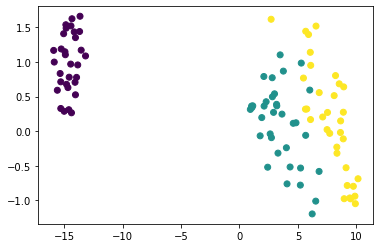

In [ ]:
plot_data(X_embedded, y)

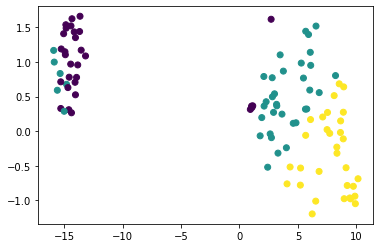

In [ ]:
plot_data(X_embedded, our_preds)

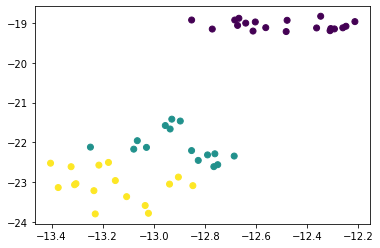

In [ ]:
plot_data(test_X_embedded, test_y)

In [28]:
loss = make_loss_function(X, y, iris_model)

In [29]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

n_its = 100

loss_track = []

for it in range(n_its):
    weights, _loss = opt.step_and_cost(loss, weights)
    if it % 5 == 0:
        our_preds = make_predictions(X, iris_model, weights, classes=3)
        print(f"Loss at iteration {it:2} = {_loss: .10f}  Accuracy = {compute_accuracy(our_preds, y): .2f}")
    loss_track.append(_loss)

Loss at iteration  0 =  0.3174341341  Accuracy =  0.58
Loss at iteration  5 =  0.2677307111  Accuracy =  0.59
Loss at iteration 10 =  0.2569744109  Accuracy =  0.63
Loss at iteration 15 =  0.2519635215  Accuracy =  0.65
Loss at iteration 20 =  0.2492564116  Accuracy =  0.71
Loss at iteration 25 =  0.2476647060  Accuracy =  0.71
Loss at iteration 30 =  0.2466626429  Accuracy =  0.71
Loss at iteration 35 =  0.2459953888  Accuracy =  0.71
Loss at iteration 40 =  0.2455302233  Accuracy =  0.71
Loss at iteration 45 =  0.2451934927  Accuracy =  0.71
Loss at iteration 50 =  0.2449419999  Accuracy =  0.71
Loss at iteration 55 =  0.2447491797  Accuracy =  0.71
Loss at iteration 60 =  0.2445980174  Accuracy =  0.71
Loss at iteration 65 =  0.2444772287  Accuracy =  0.71
Loss at iteration 70 =  0.2443791008  Accuracy =  0.71
Loss at iteration 75 =  0.2442982213  Accuracy =  0.71
Loss at iteration 80 =  0.2442307040  Accuracy =  0.71
Loss at iteration 85 =  0.2441737007  Accuracy =  0.71
Loss at it

In [31]:
our_preds = make_predictions(X, iris_model, weights, classes=3)
test_preds = make_predictions(test_X, iris_model, weights, classes=3)
print(f"Training prediction accuracy: {compute_accuracy(our_preds, y)}")
print(f"Testing prediction accuracy: {compute_accuracy(test_preds, test_y)}")

Training prediction accuracy: 0.71
Testing prediction accuracy: 0.68


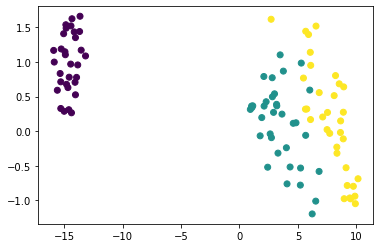

In [34]:
plot_data(X_embedded, y)

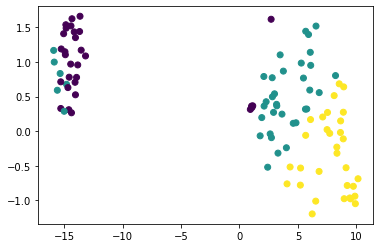

In [35]:
plot_data(X_embedded, our_preds)

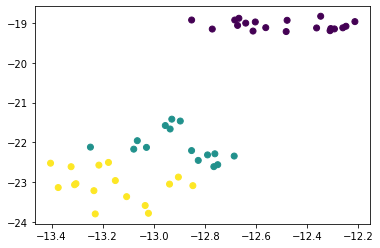

In [36]:
plot_data(test_X_embedded, test_y)

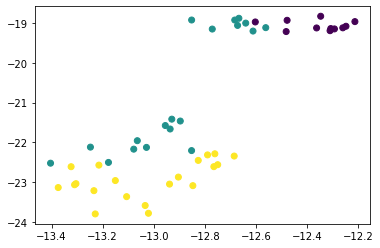

In [38]:
plot_data(test_X_embedded, test_preds)